In [69]:
import osmnx as ox
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import tracers as tr
import typing
import xml.etree.ElementTree as ET
import numpy as np

In [70]:
simple_lat_lon_list = [
    (43.7274446, 7.4132824),
    (43.7284912, 7.4149668),
    (43.7297472, 7.4164581),
    (43.7311969, 7.4188507),
    (43.7318249, 7.4214149),
    (43.7321117, 7.4230134),
    (43.7336234, 7.4216938),
    (43.7361196, 7.4212968),
    (43.7376855, 7.4257171),
    (43.7397164, 7.4252021),
    (43.7397242, 7.4232495),
    (43.7398792, 7.4217904)
]

In [71]:
# load graph
G = ox.load_graphml(filepath='data/monaco.graphml')

# Load the GPX file
gpx_file = r"data/1018073635-53020.gpx"

# Parse the GPX file using ElementTree
tree = ET.parse(gpx_file)
root = tree.getroot()

# Define a list to store the latitude and longitude pairs
lat_lon_list = []

# Iterate through the track points (trkpt elements)
for trkpt in root.findall(".//{http://www.topografix.com/GPX/1/0}trkpt"):
    # Extract latitude and longitude attributes
    lat = float(trkpt.get("lat"))
    lon = float(trkpt.get("lon"))
    
    lat_lon_list.append((lat, lon))

# pertrubedlatlon = tr.uniform_perturb_trace(lat_lon_list, 50)
pertrubedlatlon = tr.uniform_perturb_trace(simple_lat_lon_list, 50)

In [72]:
# get the boundarie box of the trace


minlat = min([p[0] for p in pertrubedlatlon])
maxlat = max([p[0] for p in pertrubedlatlon])
minlon = min([p[1] for p in pertrubedlatlon])
maxlon = max([p[1] for p in pertrubedlatlon])

# print before enlarge
# add 200m to each side
bbox = tr.enlarge_bbox((maxlat,minlat, maxlon, minlon), 200)

# query osmnx with a bbox
G2 = ox.graph_from_bbox(*bbox, network_type='all')

# G2 nodes to lat,lon tuples
G2latlon = []
for node in G2.nodes:
    G2latlon.append((G2.nodes[node]['y'], G2.nodes[node]['x'], node))

# G2 nodes to lat,lon,highw
candidate_lists : typing.List[typing.List[int]] = tr.graph_to_candidates_ids(G2latlon, pertrubedlatlon, radius = 100)

# candidates list push front the closest node to the first point in the trace
candidate_lists.insert(0, [ox.distance.nearest_nodes(G2, *pertrubedlatlon[0])])
# candidates list push back the closest node to the last point in the trace
candidate_lists.append([ox.distance.nearest_nodes(G2, *pertrubedlatlon[-1])])

ox.add_edge_bearings(G2)

# a numpy array of shape (3,1)
weights_global = np.array([0,0,1]) # for now only take the distance into account, which is the third element

In [84]:
# a dataclass called M
DEBUG = False


class M:
    def __init__(self, candidate_lists: typing.List[typing.List[int]], graph):
        self.graph: nx.MultiDiGraph = graph
        # TODO: check if bearings are in the graph, if not add them
        self.candidate_lists = candidate_lists
        self.backpointers = [{c: c for c in clist}for clist in candidate_lists]
        self.hidden_states = [{c: None for c in clist}
                              for clist in candidate_lists]
        self.gains = [{c: 0.0 for c in clist} for clist in candidate_lists]

        self.hidden_states[0] = {candidate_lists[0][0]: None}

        self.micro_k = 1

        # for now only take the distance into account, which is the third element
        self.weights = np.array([0, 0, 1])

    def viterbi(self) -> typing.List[int]:
        for t in range(1, len(self.candidate_lists)):
            if DEBUG:
                print(f"t={t}")
            prev_viterbi = candidate_lists[t-1]
            curr_viterbi = candidate_lists[t]

            # filter the prev_viterbi list only on the ones that have non negative gain!
            valid_prev_viterbi = list(filter(
                lambda x: self.gains[t-1][x] >= 0, prev_viterbi))
            if len(valid_prev_viterbi) == 0:
                raise Exception(
                    f"Couldn't find a valid path between t={t-1} and t={t}")
            # for each candidate in the current viterbi check which prev_id should be chosen
            for cand_id in curr_viterbi:
                # map the choice of prev_viterbi to the gain which is the path gain + the gain to get to prev_id
                def gain_to_prev_id(prev_id): return self.gains[t-1][prev_id]
                prev_rating_delta = {prev_id: self._calc_prev_to_curr_gain(
                    prev_id, cand_id, t) for prev_id in valid_prev_viterbi}
                # make dict for each prev_id : bestpath,totalgain
                # summing with -1 gives -1 which is the "no path found" indicator
                # micropath is the first item in the tuple, not used currently
                prev_rating = {prev_id: (prev_rating_delta[prev_id][0], (gain_to_prev_id(
                    prev_id) + prev_rating_delta[prev_id][1]) if prev_rating_delta[prev_id][1] >= 0 else -1) for prev_id in valid_prev_viterbi}
                # TODO: save the best path somewhere
                best_prev_id, (_, best_gain) = max(
                    prev_rating.items(), key=lambda x: x[1][1])
                self.backpointers[t][cand_id] = best_prev_id
                self.gains[t][cand_id] = best_gain

        # backtrack
        best_path = []
        curr_id = candidate_lists[-1][0]
        for t in range(len(candidate_lists)-1, 0, -1):
            best_path.insert(0, curr_id)
            curr_id = self.backpointers[t][curr_id]
        return best_path

    def _calc_prev_to_curr_gain(self, start_id, end_id, t) -> typing.Tuple[typing.List[int], float]:
        """
        returns the best path from start_id to end_id and the gain
        best path is a list of node_ids!
        """
        # calc k shortest paths
        # TODO: calculate k based on context
        shortest_paths_nodes = ox.k_shortest_paths(
            G=self.graph, orig=start_id, dest=end_id, k=self.micro_k, weight='length')
        # try getting paths from the generator and calculate the gain
        try:
            bestpath, gain = max([(path, self._calc_single_path_gain(
                path, t)) for path in shortest_paths_nodes], key=lambda x: x[1])
            return bestpath, gain

        except nx.NetworkXNoPath:
            # no path found, gain is negative
            return [], -1

    def _calc_single_path_gain(self, path: typing.List[int], t) -> float:
        # to convert nodes to edges:
        def shortest_path_edge(i): return self.graph.get_edge_data(
            path[i], path[i+1])[0]
        # get starting state by querying hiddenstates with the first node in the path
        start_state = self.hidden_states[t-1][path[0]]
        if start_state is None:
            prev_bearing = None
        else:
            prev_bearing = start_state["last_edge"]["bearing"]
        stacked_features = np.zeros((len(path)-1, 3))
        # loop through the edges in the path
        for i in range(len(path)-1):
            curr_edge = shortest_path_edge(i)
            curr_bearing = curr_edge["bearing"]
            if prev_bearing is None:
                delta_bearing = 0
            else:
                delta_bearing = curr_bearing - prev_bearing
            # update prev_bearing
            prev_bearing = curr_bearing
            # feature is split into magintude and direction
            delta_bearing_abs = abs(delta_bearing)
            delta_bearing_dir = np.sign(delta_bearing)
            # distance
            delta_distance = curr_edge["length"]
            # TODO: other features: road type, timedelta, etc.
            feature_vector = np.array(
                [delta_bearing_abs, delta_bearing_dir, delta_distance])
            stacked_features[i] = feature_vector
        total_gain = np.sum(stacked_features * self.weights)
        return total_gain

In [85]:
# Test with simple lat lon list
offmodel :M = M(candidate_lists, G2)
DEBUG = True
best_path = offmodel.viterbi()
# save as pickle
import pickle
with open('data/best_path.pkl', 'wb') as f:
    pickle.dump(best_path, f)

t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
t=9
t=10
t=11
t=12
t=13


In [92]:
# for osmid in best_path, bet lat,lon
best_path_latlon = []
for osmid in best_path:
    best_path_latlon.append((G2.nodes[osmid]['y'], G2.nodes[osmid]['x']))


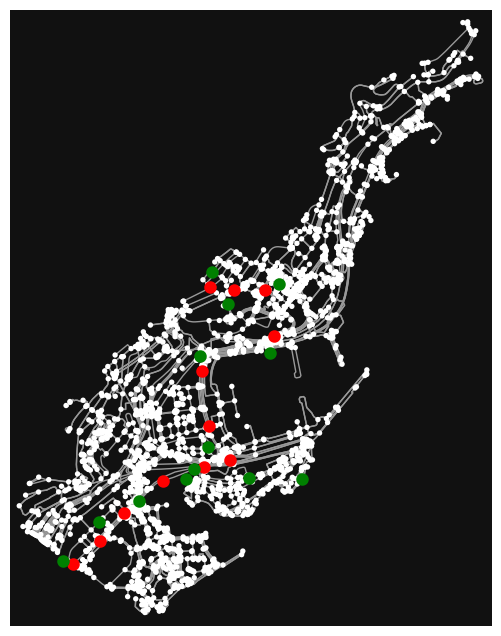

In [94]:
best_path
# plot the best path with osmnx
# same but make the trace thicker
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.scatter([p[1] for p in simple_lat_lon_list], [p[0] for p in simple_lat_lon_list], c='r', linewidth=3)
ax.scatter([p[1] for p in best_path_latlon], [p[0] for p in best_path_latlon], c='g', linewidth=3)
